# (Tut 1) Deep Learning Deep Inelastic Scattering at EIC

**Credits:**

Heavily based on:

- *Reconstructing the Kinematics of Deep Inelastic Scattering with Deep Learning* by Miguel Arratia, Daniel Britzger, Owen Long, Benjamin Nachman arXiv:2110.05505 --- [[code](https://github.com/owen234/DIS-reco-paper), [dataset](https://drive.google.com/file/d/1Z-lUTZrHoqeKsYHf34gR3kF45bVM6XG7/view)]

- *Deeply Learning Deep Inelastic Scattering Kinematics*, by Markus Diefenthaler, Abdullah Farhat, Andrii Verbytskyi, Yuesheng Xu,arXiv:2108.11638




## Training for H1 rapgap MC with reconstructed observables as input.
### This uses a single DNN with all inputs (electron, HFS, photons)
Adjust Huber delta to 0.01.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Make sure GPU runtime is enabled.
# Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU
# You will likely only have a T4, unless you have colab pro.
!nvidia-smi

Wed Jun 14 15:41:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# We need uproot3 to unpack the ROOT file.
!pip install uproot3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 13.4 MB/s eta 0:00:00


In [5]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess

import seaborn as sns


In [6]:
#has_gpu = False

has_gpu = True

training_name = 'training_h1_reg_hugs23_v2'

training_extname = "/content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/"+training_name

#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
max_events = 10e6
#max_events =  3000000
#max_events = 15000000


learning_rate_setval_reg = 1e-5
batch_size_setval = 1024
max_epochs = 50
dropout_setval = 0.0
amsgrad_setval = False
delta_setval = 0.01

# Path to the ROOT file in your google drive. Make sure your drive is mounted above.
input_file = '/content/drive/My Drive/projects/DIS-reco/data/all-h1-rapgap.root'

outprintfile = training_extname+"-setup.txt"

parfile = open(outprintfile,'w')

parfile.write('%s\n' % datetime.now())
parfile.write('training_name : %s\n' % training_extname )
parfile.write('input_file : %s\n' % input_file )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )
parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
parfile.write('delta_setval : %g\n' % delta_setval )

parfile.close()

command_string = ("cat '%s'")% outprintfile

print( subprocess.getoutput(command_string) )
print('\n\n')






2023-06-14 15:41:22.976163
training_name : /content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/training_h1_reg_hugs23_v2
input_file : /content/drive/My Drive/projects/DIS-reco/data/all-h1-rapgap.root
max_events : 10000000
learning_rate_setval_reg : 1e-05
batch_size_setval : 1024
max_epochs : 50
dropout_setval : 0
amsgrad_setval : 0
delta_setval : 0.01





In [7]:
%%time

ur_file = uproot3.open(input_file)

print("ur_file.keys(): ", ur_file.keys())

ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()

#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40',
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e'
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )


ur_file.keys():  [b'Rapgap;1']
<TTree b'minitree' at 0x7f15cdbe4760>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no s

In [8]:
print(len(pandas_df))
pandas_df.head()

10000000


,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi,Empz,obs_e_trk_e,beam_e_e
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
1,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
2,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
3,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6
4,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.6


In [9]:
pandas_df.tail()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,obs_e_pt,obs_e_phi,obs_hfs_e,obs_hfs_pz,obs_hfs_pt,obs_hfs_phi,obs_dphi,Empz,obs_e_trk_e,beam_e_e
entry,,,,,,,,,,,,,,,,,,,,,
9999995,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6
9999996,0,1,47.094521,2,-0.124716,8.941693,2.411923,0.058500,0.058319,0.057878,...,37.800995,2.692896,119.429268,97.070717,37.856754,-0.424569,3.117465,55.341942,39.459339,27.6
9999997,0,0,17.333700,1,-0.806077,0.196039,0.073661,0.004271,0.002905,0.004672,...,10.322068,-2.546395,49.432240,26.698160,10.748409,0.720433,3.016356,53.993011,16.515560,27.6
9999998,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6
9999999,0,1,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.6


In [10]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [11]:
pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )

In [12]:
pandas_df.head()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-2.582836,-4.780699,3.588407,NaN,-1.0,False,NaN,1.0
1,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4.570547,-0.797988,5.435722,NaN,-1.0,False,NaN,1.0
2,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4.374308,-2.930975,4.217414,NaN,-1.0,False,NaN,1.0
3,1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-5.914076,-0.427778,2.654275,NaN,-1.0,False,NaN,1.0
4,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4.279663,-0.961149,6.287672,NaN,-1.0,True,NaN,1.0


In [13]:
nan_columns = pandas_df.columns[pandas_df.isna().any()].tolist()
print(nan_columns)

['obs_x[3]', 'obs_x[4]', 'obs_x[6]', 'obs_x[7]', 'obs_y[3]', 'obs_y[6]', 'obs_y[7]', 'obs_Q2[3]', 'obs_Q2[6]', 'obs_Q2[7]', 'e_ecal_over_trk_ratio', 'obs_ptbal']


In [14]:
pandas_df.columns

Index(['has_isr', 'has_fsr', 'tower_sum_40', 'n_towers_40',
       'eta_pho_closest_to_ebeam', 'e_pho_closest_to_ebeam',
       'phi_pho_closest_to_ebeam', 'obs_x[0]', 'obs_x[1]', 'obs_x[2]',
       'obs_x[3]', 'obs_x[4]', 'obs_x[5]', 'obs_x[6]', 'obs_x[7]', 'obs_x[8]',
       'obs_y[0]', 'obs_y[1]', 'obs_y[2]', 'obs_y[3]', 'obs_y[4]', 'obs_y[5]',
       'obs_y[6]', 'obs_y[7]', 'obs_y[8]', 'obs_Q2[0]', 'obs_Q2[1]',
       'obs_Q2[2]', 'obs_Q2[3]', 'obs_Q2[4]', 'obs_Q2[5]', 'obs_Q2[6]',
       'obs_Q2[7]', 'obs_Q2[8]', 'from_tlv_gen_Q2', 'from_tlv_gen_x',
       'from_tlv_gen_y', 'obs_e_e', 'obs_e_pz', 'obs_e_pt', 'obs_e_phi',
       'obs_hfs_e', 'obs_hfs_pz', 'obs_hfs_pt', 'obs_hfs_phi', 'obs_dphi',
       'Empz', 'obs_e_trk_e', 'beam_e_e', 'obs_hfs_Empz', 'obs_e_Empz',
       'obs_event_Empz', 'rot_pt1', 'rot_pt2', 'rot_Empz1', 'rot_Empz2',
       'gen_log_x', 'gen_log_y', 'gen_log_Q2', 'e_ecal_over_trk_ratio',
       'dphi_pho_closest_to_ebeam', 'has_norad', 'obs_ptbal', 'obs_pzbal']

## Apply any event selection here.

In [15]:
pandas_df = pandas_df.query('Empz > 0')

pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

# We restrict our study to events with Q2>200 GeV2.
# This kinematic region is well measured, since the electron is scattered into the central regions of the detector.
# However, no single reconstruction method gives optimal performance over the full phase space
pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )



 Number of entries in pandas_df:  2027827 


In [16]:
pandas_df.head()

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz1,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,-15.735563,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,5.847350,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,-22.754414,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,-12.849410,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,-32.666924,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048


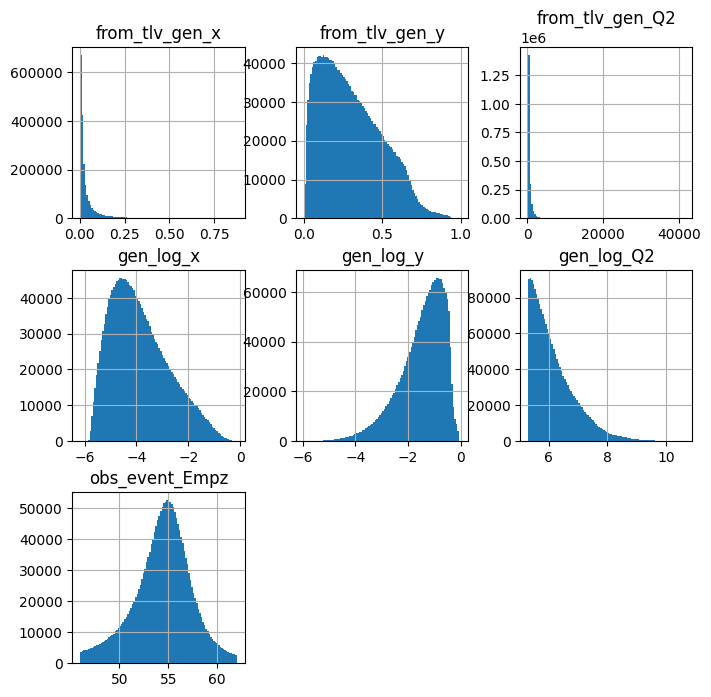

In [17]:
pandas_df.hist( figsize=(8,8), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz',
                        ])
plt.show()

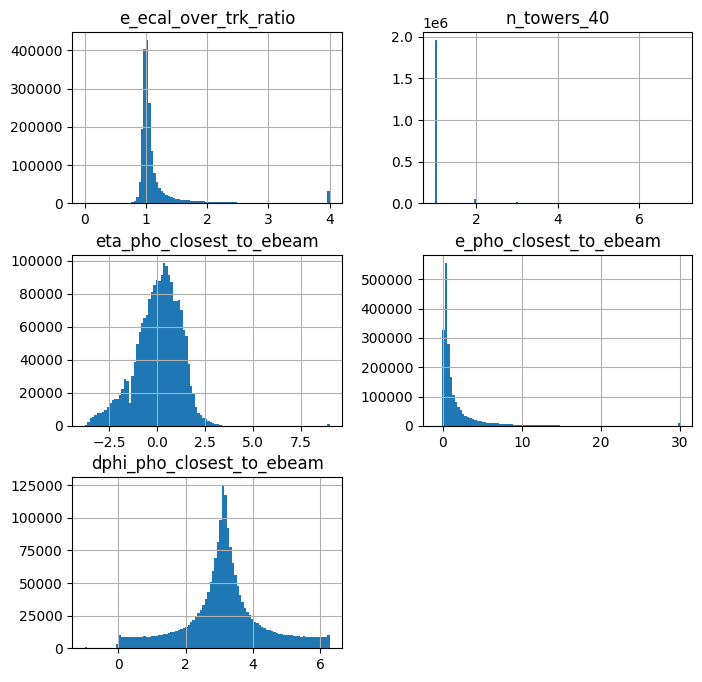

In [18]:

pandas_df.hist( figsize=(8,8), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


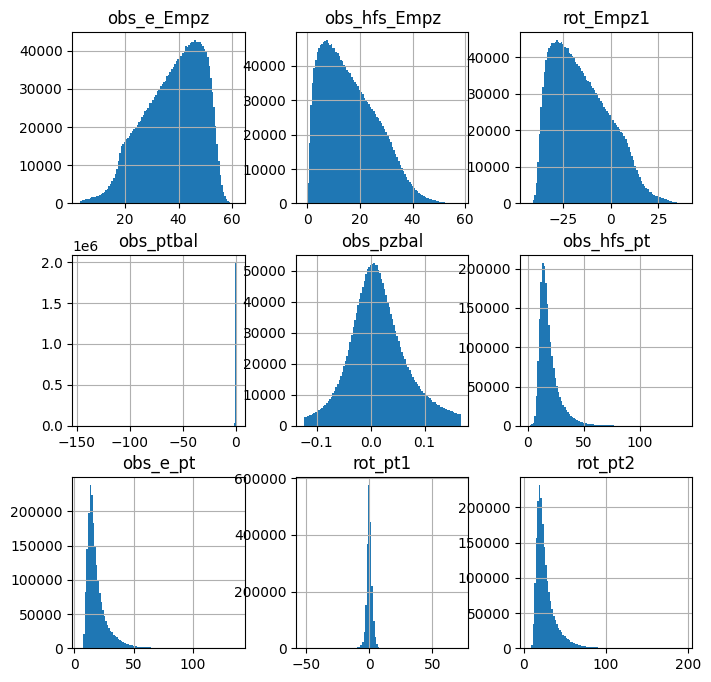

In [19]:
pandas_df.hist( figsize=(8,8), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

plt.show()

## Set up machine learning

In [20]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump

from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
# Let's select the features that are used in the paper

sel_list =  ('e_ecal_over_trk_ratio','n_towers_40','eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam','dphi_pho_closest_to_ebeam','obs_e_pz','obs_e_e','obs_hfs_pz','obs_hfs_e', 'rot_pt1', 'rot_Empz1', 'rot_pt2', 'obs_pzbal', 'obs_ptbal', 'obs_dphi')
sel_list = list(sel_list)

target_list = ('gen_log_x','gen_log_Q2','gen_log_y')
target_list = list(target_list)

sel_X = pandas_df[sel_list]
target_y = pandas_df[target_list]

sub_df = sel_X[: 1000]
corr_matrix = sub_df.corr()


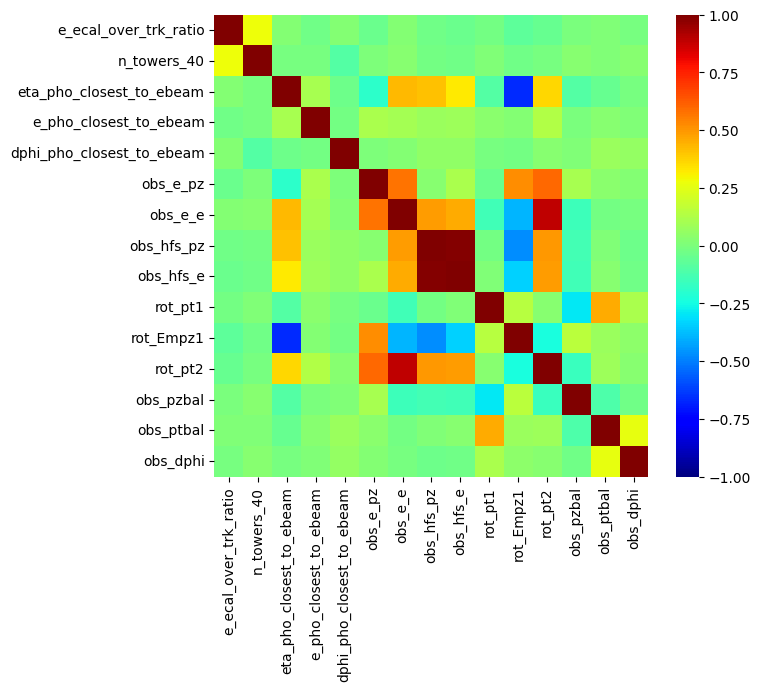

In [22]:
plt.figure(figsize=(7, 6))

sns.heatmap(corr_matrix, cmap='jet', vmin=-1, vmax=1,
            annot=False, fmt='.2f', xticklabels=sub_df.columns, yticklabels=sub_df.columns)
plt.show()

In [23]:
X = sel_X.values

Y_r = target_y.values

GY = pandas_df['from_tlv_gen_y'].to_numpy()

scalerX = StandardScaler()
scalerX.fit(X)
X = scalerX.transform(X)

scalerY = StandardScaler()
scalerY.fit(Y_r)
Y_r = scalerY.transform(Y_r)

#-- Save the scaler transformations!  These are essential when reusing the training with a different dataset.

try:
    os.mkdir( '%s-scalers' % training_extname )
except:
    print('\n  Dir %s-scalers already exists\n\n' % training_extname )


print('\n\n Saving the input and learning target scalers:\n')
print('    %s-scalers/input_scaler.pkl' % training_extname )
print('    %s-scalers/target_scaler.pkl' % training_extname )

dump( scalerX, open('%s-scalers/input_scaler.pkl' % training_extname , 'wb'))
dump( scalerY, open('%s-scalers/target_scaler.pkl' % training_extname , 'wb'))

X_train, X_test, Y_r_train, Y_r_test, GY_train, GY_test = train_test_split( X,  Y_r, GY,  test_size=0.5)



  Dir /content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/training_h1_reg_hugs23_v2-scalers already exists




 Saving the input and learning target scalers:

    /content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/training_h1_reg_hugs23_v2-scalers/input_scaler.pkl
    /content/drive/My Drive/projects/DIS-reco/DIS-reco-paper/training_h1_reg_hugs23_v2-scalers/target_scaler.pkl


In [24]:
print(type(X),np.shape(X))

<class 'numpy.ndarray'> (2027827, 15)


In [25]:
print(np.shape(X_train),np.shape(Y_r_train))
print(np.shape(X_test),np.shape(Y_r_test))
print("GY_train shape: ",np.shape(GY_train))
print("GY_test shape: ",np.shape(GY_test))

(1013913, 15) (1013913, 3)
(1013914, 15) (1013914, 3)
GY_train shape:  (1013913,)
GY_test shape:  (1013914,)


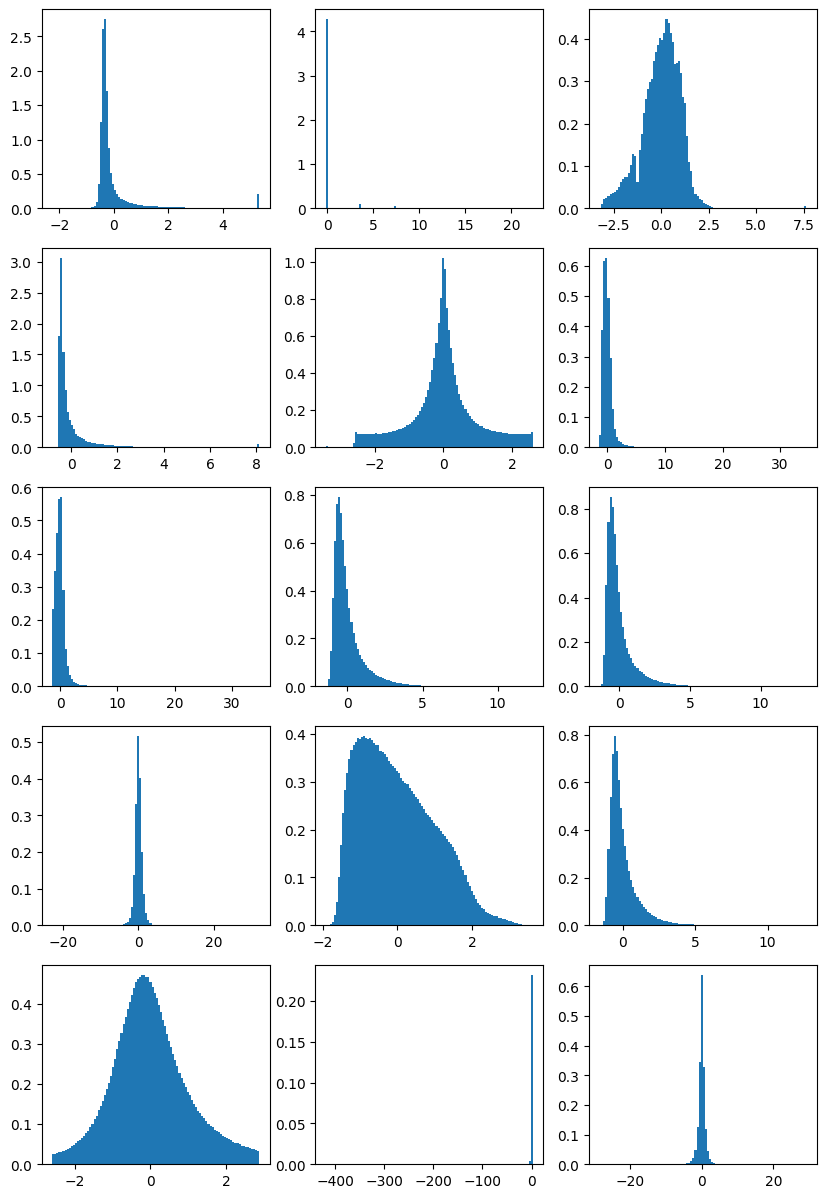

In [26]:
fig, ax = plt.subplots(5, 3, figsize=(10, 15))

for i in range(5):
    for j in range(3):
        idx = i * 3 + j
        if idx < X.shape[1]:  # check if we're still within the number of columns in X
            ax[i][j].hist(X[:, idx], density=True, bins=100)
        else:
            ax[i][j].axis('off')  # turn off remaining axes

plt.show()

## Set up the regression network

In [27]:
model_r = Sequential()

#-- initial layer
model_r.add(Dense(64, input_dim=15, activation='relu'))
model_r.add(Dropout(dropout_setval)) # another regularization technique used to prevent overfitting (used during training) --- drops neurons

#-- middle part
model_r.add(Dense(128, activation='selu'))
#Scaled Exponential Linear Unit ---  return scale * x. if x < 0: return scale * alpha * (exp(x) - 1)
#Mitigates the Vanishing Gradient Problem, Reduce overfitting, self-normalizing property in each layer
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(1024, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(512, activation='selu'))
model_r.add(Dropout(dropout_setval))
model_r.add(Dense(128, activation='selu'))
model_r.add(Dropout(dropout_setval))

#-- final layers
model_r.add(Dense(64, activation='selu'))
model_r.add(Dense(3, activation='linear'))

opt_r = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval_reg, amsgrad=amsgrad_setval )
# Adaptive moment estimation --- see lecture notes
myloss_r = tf.keras.losses.Huber( delta=delta_setval )

#model_r.compile(loss=myloss_r, optimizer=opt_r, metrics=['mean_absolute_error'])
model_r.compile(loss=myloss_r, optimizer=opt_r)
# HUBER
#L(y, f(x)) = 0.5 * (y - f(x))^2                        for |y - f(x)| <= delta
#L(y, f(x)) = delta * |y - f(x)| - 0.5 * delta^2        for |y - f(x)| > delta
# less sensitive to outliers compared to MSE

model_r.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5

In [28]:
%%time

hist_r = model_r.fit(
    X_train, Y_r_train,
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1,
    validation_data=(X_test,Y_r_test),
    callbacks=[earlystopping] )

Epoch 1/50
991/991 [==============================] - 17s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2/50
991/991 [==============================] - 8s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/50
991/991 [==============================] - 9s 9ms/step - loss: 9.7138e-04 - val_loss: 9.2966e-04
Epoch 4/50
991/991 [==============================] - 9s 9ms/step - loss: 8.9844e-04 - val_loss: 8.7709e-04
Epoch 5/50
991/991 [==============================] - 8s 8ms/step - loss: 8.4900e-04 - val_loss: 8.4973e-04
Epoch 6/50
991/991 [==============================] - 10s 10ms/step - loss: 8.1356e-04 - val_loss: 8.2236e-04
Epoch 7/50
991/991 [==============================] - 8s 8ms/step - loss: 7.8560e-04 - val_loss: 7.8089e-04
Epoch 8/50
991/991 [==============================] - 8s 8ms/step - loss: 7.6317e-04 - val_loss: 7.8277e-04
Epoch 9/50
991/991 [==============================] - 11s 11ms/step - loss: 7.4407e-04 - val_loss: 7.5637e-04
Epoch 10/50
991/991 [==================

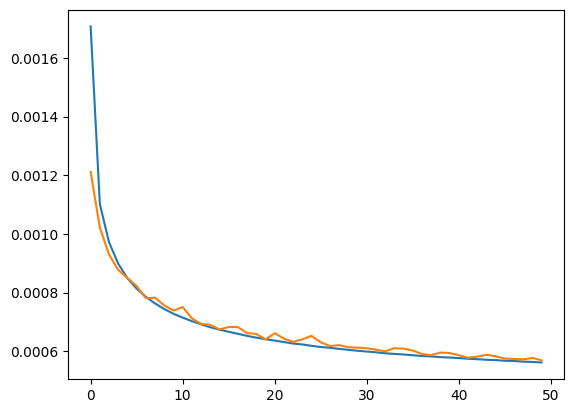

In [29]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])

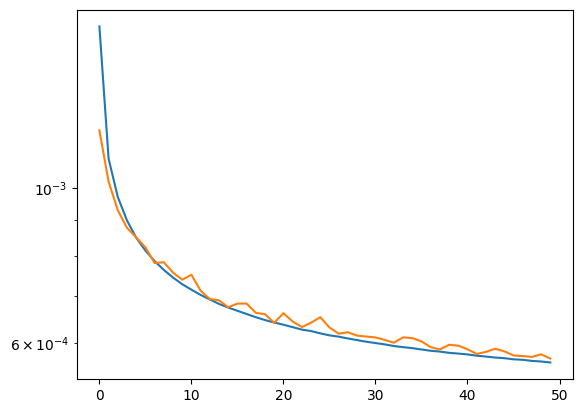

In [30]:
plt.plot(hist_r.history['loss'])
plt.plot(hist_r.history['val_loss'])
plt.yscale('log')

In [31]:
filepath_model = training_extname + "_regression"

tf.keras.models.save_model(model_r,filepath_model)

In [32]:
mypreds_r = model_r.predict(X_test,batch_size=1000)

1014/1014 [==============================] - 2s 2ms/step


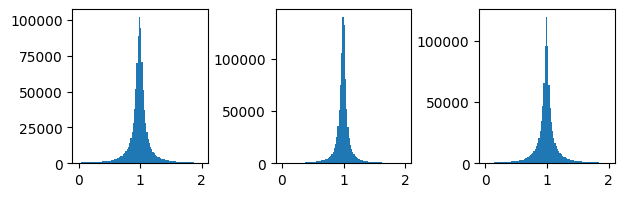

In [33]:
fig,ax = plt.subplots(1,3,figsize=(7,2))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.subplots_adjust(wspace=0.5)
plt.show()

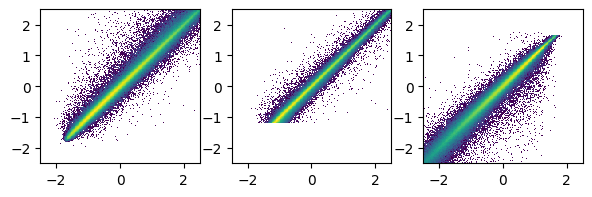

In [34]:
fig,ax = plt.subplots(1,3,figsize=(7,2))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

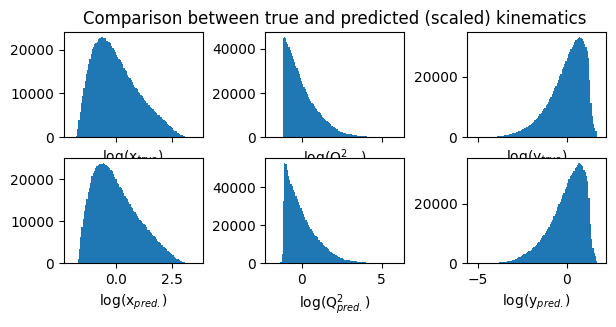

In [35]:
fig,ax = plt.subplots(2,3,figsize=(7,3), sharex='col')

# define titles and x-labels
true_labels = ['log(x$_{true})$', 'log(Q$^2_{true})$', 'log(y$_{true})$']
pred_labels = ['log(x$_{pred.})$', 'log(Q$^2_{pred.})$', 'log(y$_{pred.})$']

ax[0][1].set_title("Comparison between true and predicted (scaled) kinematics") # title for the first row

for i in range(3):
    ax[0][i].hist(Y_r_test[:,i], bins=100)
    ax[0][i].set_xlabel(true_labels[i]) # x-label for the upper plots

    ax[1][i].hist(mypreds_r[:,i], bins=100)
    ax[1][i].set_xlabel(pred_labels[i]) # x-label for the lower plots

plt.subplots_adjust(wspace=0.45)
plt.show()

In [36]:
# Inverse transform to their unscaled values (i.e., before standard scaling)

inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y)
pred_vals = np.exp( inv_trans_pred)

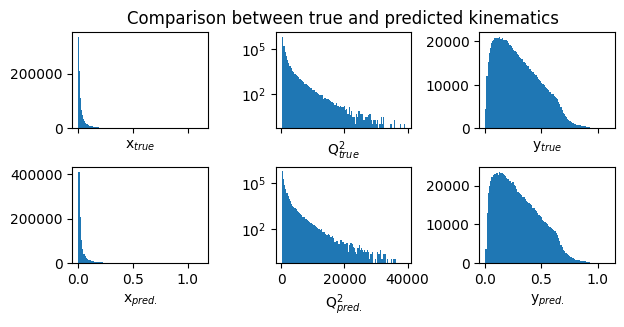

In [37]:
fig,ax = plt.subplots(2,3,figsize=(7,3), sharex='col')

# define titles and x-labels
true_labels = ['x$_{true}$', 'Q$^2_{true}$', 'y$_{true}$']
pred_labels = ['x$_{pred.}$', 'Q$^2_{pred.}$', 'y$_{pred.}$']

ax[0][1].set_title("Comparison between true and predicted kinematics") # title for the first row

for i in range(3):
    ax[0][i].hist(true_vals[:,i], bins=100)
    ax[0][i].set_xlabel(true_labels[i]) # x-label for the upper plots

    ax[1][i].hist(pred_vals[:,i], bins=100)
    ax[1][i].set_xlabel(pred_labels[i]) # x-label for the lower plots

ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.5)
plt.show()

## Plots of Ratio(pred/true) for target variables : transformed log(x), log(y), and log(Q2)

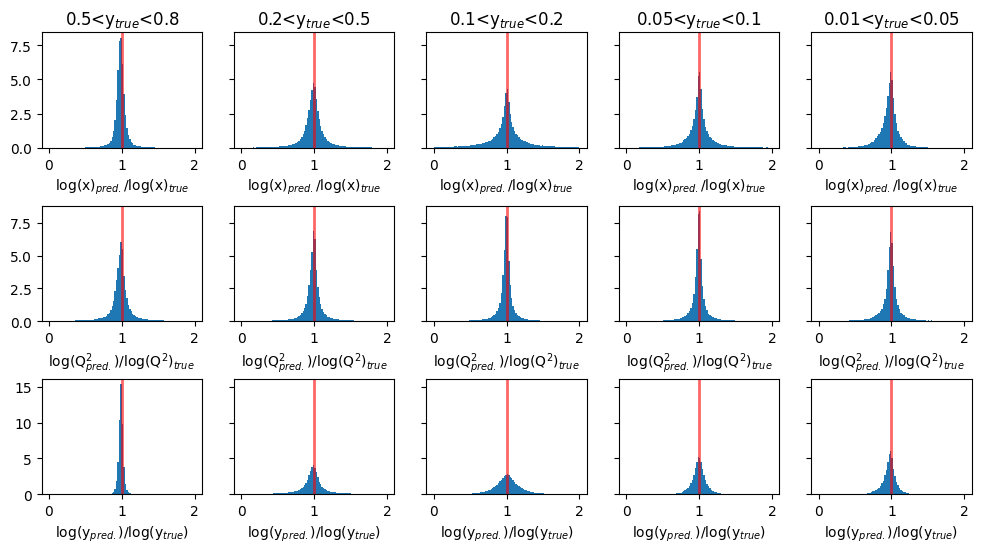

In [38]:
fig, ax = plt.subplots(3,5, figsize=(12,6), sharey='row')

titles = ['log(x)$_{pred.}$/log(x)$_{true}$', 'log(Q$^2_{pred.}$)/log(Q$^2$)$_{true}$', 'log(y$_{pred.}$)/log(y$_{true}$)']
y_ranges = [
    (0.5, 0.8),
    (0.2, 0.5),
    (0.1, 0.2),
    (0.05, 0.1),
    (0.01, 0.05)
]

for i in range(3):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist(mypreds_r[:,i][mask]/Y_r_test[mask][:,i],
                      density=True,bins=100,range=(0,2))
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)
        ax[i][j].set_xlabel(titles[i])  # set column x-label

        if i == 0:
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')

plt.subplots_adjust(hspace=0.5)
plt.show()


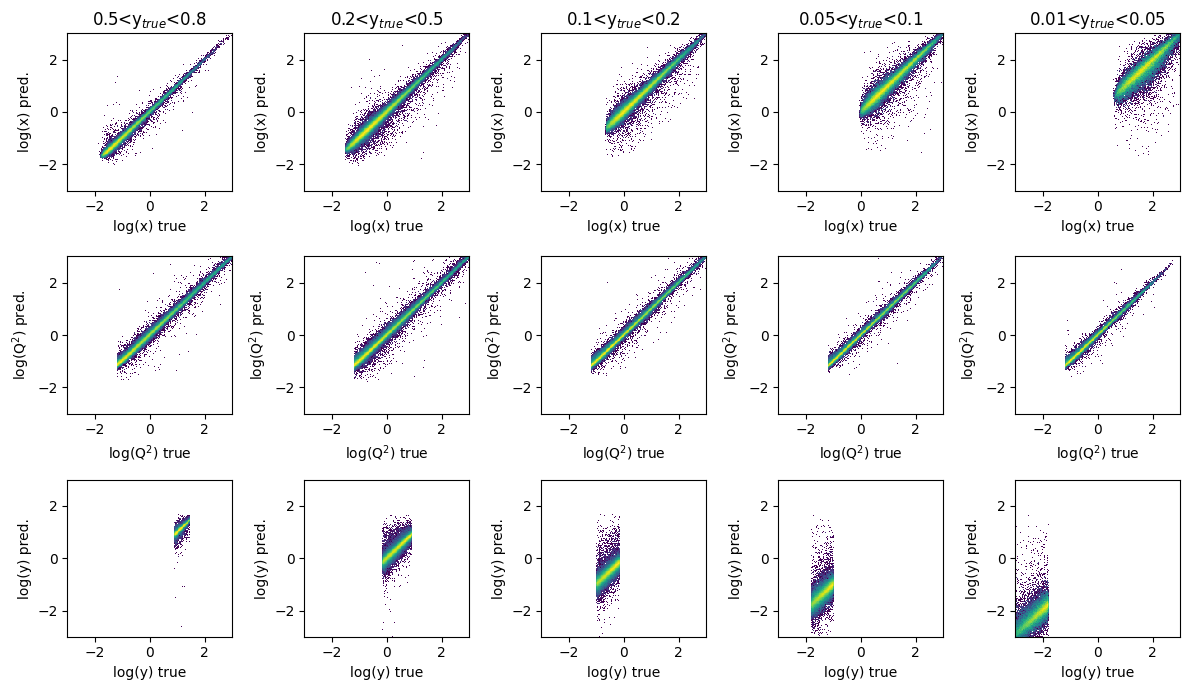

In [39]:
fig, ax = plt.subplots(3, 5, figsize=(12, 7))

titles = ['log(x)', 'log(Q$^2$)', 'log(y)']
y_ranges = [
    (0.5, 0.8),
    (0.2, 0.5),
    (0.1, 0.2),
    (0.05, 0.1),
    (0.01, 0.05)
]

for i in range(3):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist2d(Y_r_test[mask][:,i],
                        mypreds_r[:,i][mask],
                        density=True,bins=200,range=([-3,3],[-3,3]),
                        norm=mpl.colors.LogNorm())

        if i == 0:
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')

        ax[i][j].set_ylabel(titles[i] + ' pred.')
        ax[i][j].set_xlabel(titles[i] + ' true')

plt.tight_layout()
plt.show()


## Plots of predicted and true physics variable : x

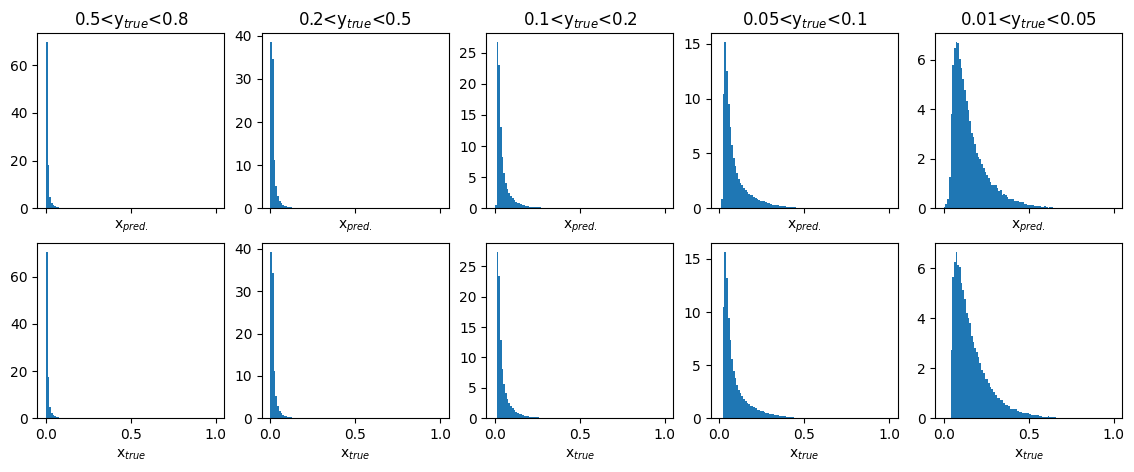

In [40]:
fig,ax = plt.subplots(2,5,figsize=(14,5),sharex='col')

y_ranges = [(0.5, 0.8),(0.2, 0.5),(0.1, 0.2),(0.05, 0.1),(0.01, 0.05)]

for i in range(2):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        if i == 0:
            ax[i][j].hist(pred_vals[:,0][mask],density=True,bins=100,range=(0,1))
            ax[i][j].set_title(f'{y_min}<y$_{{true}}$<{y_max}')
            ax[i][j].set_xlabel('x$_{pred.}$')
        else:
            ax[i][j].hist(true_vals[:,0][mask],density=True,bins=100,range=(0,1))
            ax[i][j].set_xlabel('x$_{true}$')

plt.show()


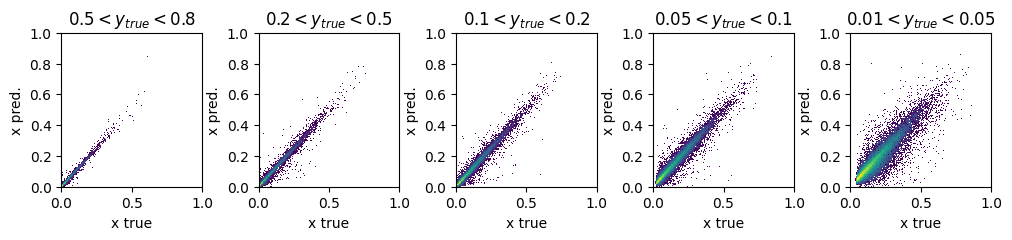

In [41]:
fig, ax = plt.subplots(1,5, figsize=(12,2))

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5<y_{true}<0.8$', '$0.2<y_{true}<0.5$', '$0.1<y_{true}<0.2$', '$0.05<y_{true}<0.1$', '$0.01<y_{true}<0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:,0][mask], pred_vals[:,0][mask],
                 density=True, bins=200, range=([0,1],[0,1]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('x true')
    ax[i].set_ylabel('x pred.')


plt.subplots_adjust(wspace=0.4)

plt.show()


## Plots of predicted and true physics variable : Q2

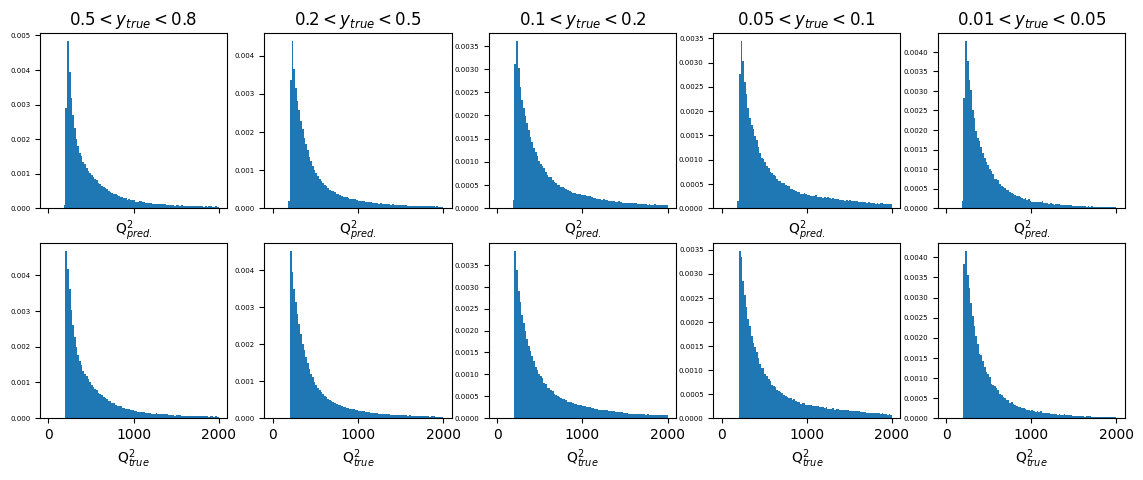

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(14, 5), sharex='col')

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
xmax = 2000
titles = ['$0.5<y_{true}<0.8$', '$0.2<y_{true}<0.5$', '$0.1<y_{true}<0.2$', '$0.05<y_{true}<0.1$', '$0.01<y_{true}<0.05$']
x_labels = ['Q$^{2}_{pred.}$', 'Q$^{2}_{true}$']

for i in range(2):
    for j in range(5):
        y_min, y_max = y_ranges[j]
        mask = (GY_test > y_min)*(GY_test < y_max)
        ax[i][j].hist(pred_vals[:,1][mask] if i == 0 else true_vals[:,1][mask],
                      density=True, bins=100, range=(0, xmax))
        if i==0:
          ax[i][j].set_title(titles[j])
        ax[i][j].set_xlabel(x_labels[i])
        ax[i][j].tick_params(axis='y', labelsize=5)  # adjust the fontsize of y-axis

plt.show()


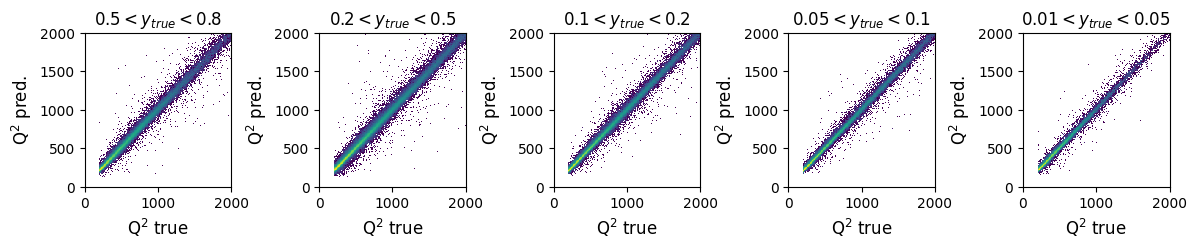

In [43]:
fig, ax = plt.subplots(1, 5, figsize=(14, 2))
axis_max = 2000

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']
x_label = 'Q$^{2}$ true'
y_label = 'Q$^{2}$ pred.'

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:, 1][mask], pred_vals[:, 1][mask],
                 density=True, bins=200, range=([0, axis_max], [0, axis_max]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Q$^{2}$ pred.')
    ax[i].set_xlabel(x_label)
    ax[i].set_xlabel(x_label, fontsize=12)
    ax[i].set_ylabel(y_label, fontsize=12)

plt.subplots_adjust(wspace=0.6)
plt.show()


## Plots of predicted and true physics variable : y

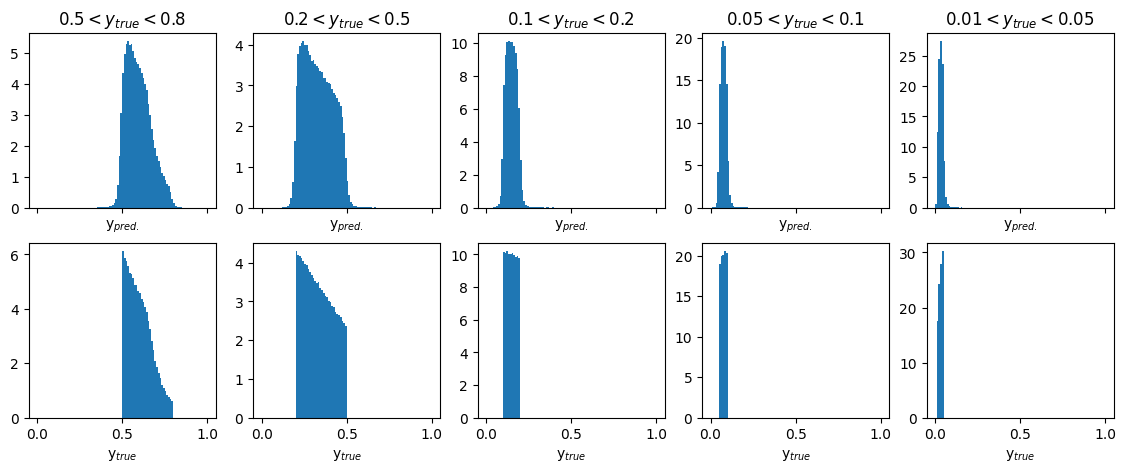

In [44]:
fig, ax = plt.subplots(2, 5, figsize=(14, 5), sharex='col')
xmax = 1

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']
x_label = ['y$_{pred.}$','y$_{true}$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[0][i].hist(pred_vals[:, 2][mask], density=True, bins=100, range=(0, xmax))
    ax[1][i].hist(true_vals[:, 2][mask], density=True, bins=100, range=(0, xmax))
    ax[0][i].set_title(titles[i])
    ax[0][i].set_xlabel(x_label[0])
    ax[1][i].set_xlabel(x_label[1])

plt.show()


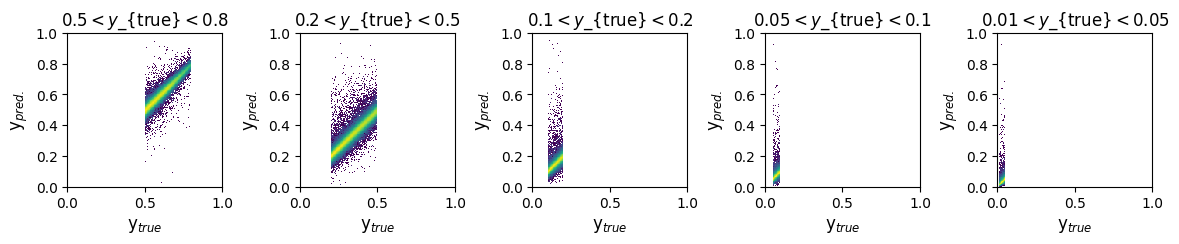

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(14, 2))
axis_max = 1

y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y$_{true}$ < 0.8$', '$0.2 < y$_{true}$ < 0.5$', '$0.1 < y$_{true}$ < 0.2$', '$0.05 < y$_{true}$ < 0.1$', '$0.01 < y$_{true}$ < 0.05$']
x_label = 'y$_{true}$'
y_label = 'y$_{pred.}$'

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist2d(true_vals[:, 2][mask], pred_vals[:, 2][mask], density=True, bins=200, range=([0, axis_max], [0, axis_max]), norm=mpl.colors.LogNorm())
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(x_label)
    ax[i].set_ylabel(y_label)
    ax[i].set_xlabel(x_label, fontsize=12)
    ax[i].set_ylabel(y_label, fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.show()


## Plots of pred/true of physics variable x

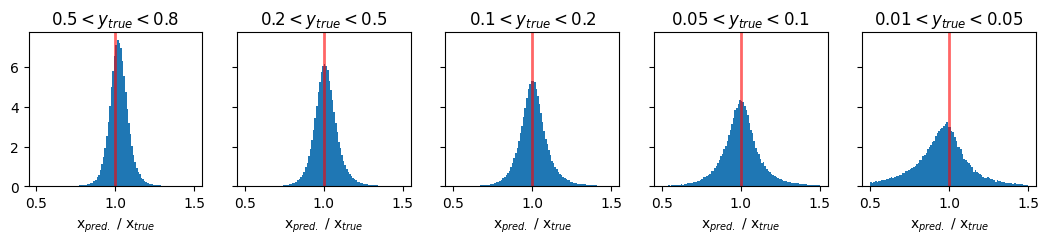

In [46]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 0][mask] / true_vals[:, 0][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('x$_{pred.}$ / x$_{true}$')

plt.show()


## Plots of pred/true of physics variable Q2

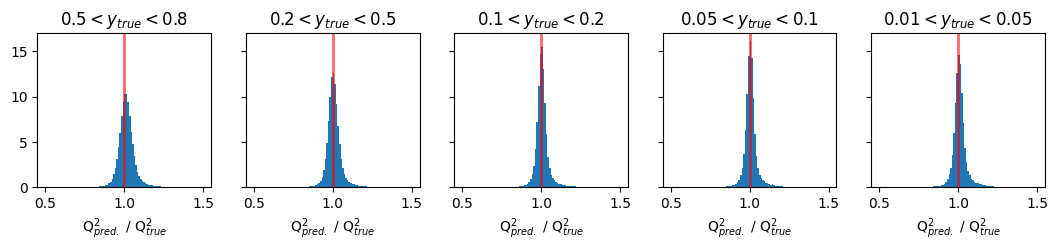

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 1][mask] / true_vals[:, 1][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('Q$^{2}_{pred.}$ / Q$^{2}_{true}$')

plt.show()


## Plots of pred/true of physics variable y

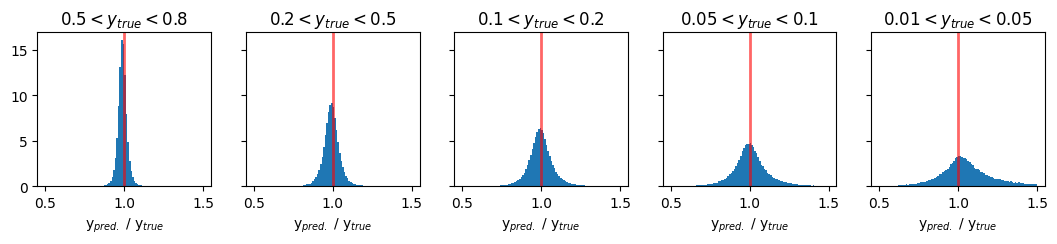

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(13, 2), sharey='row')
xmin = 0.5
xmax = 1.5
y_ranges = [(0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)]
titles = ['$0.5 < y_{true} < 0.8$', '$0.2 < y_{true} < 0.5$', '$0.1 < y_{true} < 0.2$', '$0.05 < y_{true} < 0.1$', '$0.01 < y_{true} < 0.05$']

for i in range(5):
    y_min, y_max = y_ranges[i]
    mask = (GY_test > y_min) * (GY_test < y_max)
    ax[i].hist(pred_vals[:, 2][mask] / true_vals[:, 2][mask], density=True, bins=100, range=(xmin, xmax))
    ax[i].set_title(titles[i])
    ax[i].axvline(1.0, color='red', lw=2, alpha=0.6)
    ax[i].set_xlabel('y$_{pred.}$ / y$_{true}$')

plt.show()


## Comparison plots of resolution for methods vs DNN


## Resolution in x

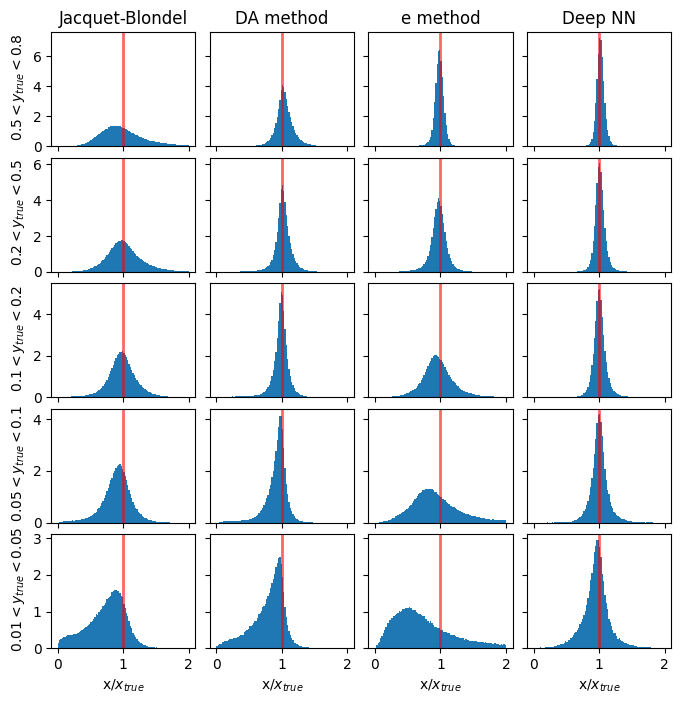

In [49]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_xratio = []
rms_xratio = []

def cal_mean_rms(bin_edges,counts, mean_l, rms_l):
  bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
  mean = np.average(bin_centers, weights=counts)
  rms = np.sqrt(np.average((bin_centers - mean) ** 2, weights=counts))
  mean_l.append(mean)
  rms_l.append(rms)
  return mean_l, rms_l

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.0
xmax = 2.0
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_x[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_x'],
                       density=True, bins=100, range=(xmin, xmax))
        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)



# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_xratio, rms_xratio= cal_mean_rms(bin_edges,counts, mean_xratio, rms_xratio)


for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('x/$x_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Resolution in Q2

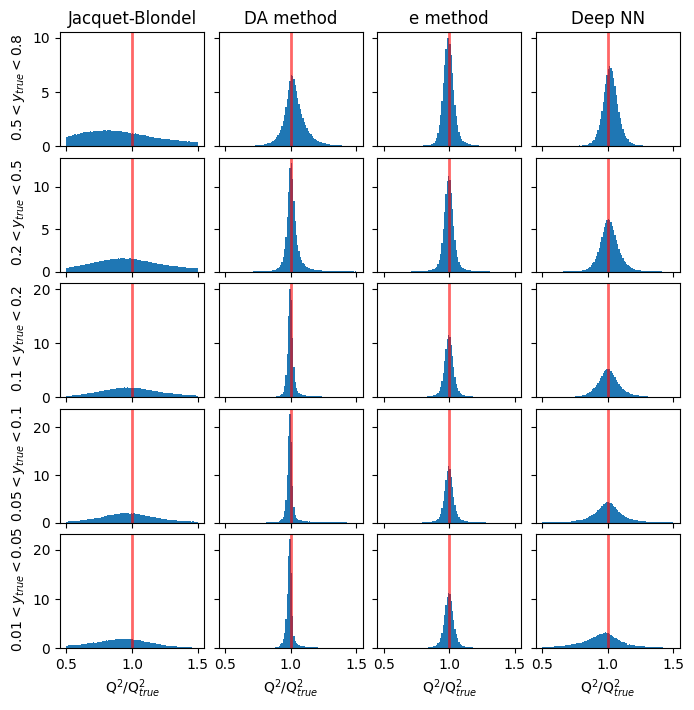

In [50]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined


mean_Q2ratio = []
rms_Q2ratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.5
xmax = 1.5
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'],
                       density=True, bins=100, range=(xmin, xmax))
        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)


# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ =  ax[yi][len(methods_to_use)].hist(pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_Q2ratio, rms_Q2ratio= cal_mean_rms(bin_edges,counts, mean_Q2ratio, rms_Q2ratio)


for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('Q$^2$/Q$^2_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Resolution in y

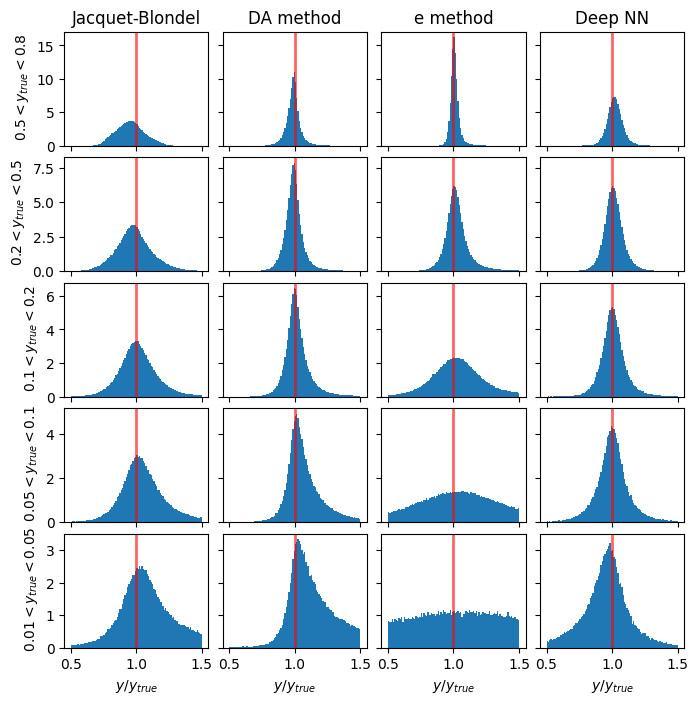

In [51]:
# y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

mean_yratio = []
rms_yratio = []

methods_to_use = [4, 3, 0] # [5, 4, 3, 0]
methods_labels = ['Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'] #'I$\Sigma$ method', 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'
xmin = 0.5
xmax = 1.5
y_cut = ['from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80','from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50','from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20','from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10','from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05']

fig, ax = plt.subplots(len(y_cut), len(methods_labels), figsize=(8, 8), sharey='row', sharex=True)


# the standard methods
for i in range(len(methods_to_use)):
    mi = methods_to_use[i]
    for yi in range(len(y_cut)):
        counts, bin_edges, _ = ax[yi][i].hist(pandas_df.query(y_cut[yi])['obs_y[%d]' % mi] / pandas_df.query(y_cut[yi])['from_tlv_gen_y'],
                       density=True, bins=100, range=(xmin, xmax))
        if(yi==0):
          ax[yi][i].set_title(methods_labels[i])

        mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)



# the DNN method
for yi in range(len(y_cut)):
    counts, bin_edges, _ = ax[yi][len(methods_to_use)].hist(pred_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])] / true_vals[:, 0][(GY_test > y_ranges[yi][0]) * (GY_test < y_ranges[yi][1])],
                   density=True, bins=100, range=(xmin, xmax))
    ax[0][len(methods_to_use)].set_title('Deep NN')

    mean_yratio, rms_yratio= cal_mean_rms(bin_edges,counts, mean_yratio, rms_yratio)



for yi, y_range in enumerate(y_ranges):
    ax[yi][0].set_ylabel(f' ${y_range[0]} < y_{{true}} < {y_range[1]}$')

if(len(y_cut)>0):
  for i in range(len(methods_to_use)+1):
      ax[len(y_cut)-1][i].set_xlabel('$y/y_{true}$')

for i in range(len(y_cut)):
    for j in range(len(methods_to_use)+1): # +1 to include DNN
        ax[i][j].axvline(1.0, color='red', lw=2, alpha=0.6)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


### Plotting the results as a function of y

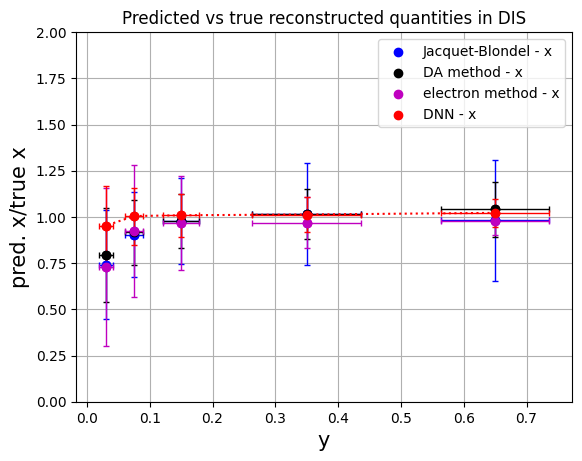

In [52]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

ykin = []
err_ykin = []

for values in y_ranges:
  tmp = 0.5*(values[0]+values[1])
  ykin.append(tmp)
  tmp = abs(values[1]-values[0])
  err_ykin.append(tmp/np.sqrt(12.))

ykin = np.array(ykin)
err_ykin = np.array(err_ykin)


meanx_jb = np.array(mean_xratio[0:5])
errx_jb = np.array(rms_xratio[0:5])

meanx_da = np.array(mean_xratio[5:10])
errx_da = np.array(rms_xratio[5:10])

meanx_e = np.array(mean_xratio[10:15])
errx_e = np.array(rms_xratio[10:15])

meanx_dnn = np.array(mean_xratio[15:20])
errx_dnn = np.array(rms_xratio[15:20])

plt.scatter(ykin, meanx_jb, color='b', label='Jacquet-Blondel - x')
plt.errorbar(ykin, meanx_jb, xerr=err_ykin, yerr=errx_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meanx_da, color='k', label='DA method - x')
plt.errorbar(ykin, meanx_da, xerr=err_ykin, yerr=errx_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meanx_e, color='m', label='electron method - x')
plt.errorbar(ykin, meanx_e, xerr=err_ykin, yerr=errx_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meanx_dnn, color='r', label='DNN - x')
plt.errorbar(ykin, meanx_dnn, xerr=err_ykin, yerr=errx_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. x/true x',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()

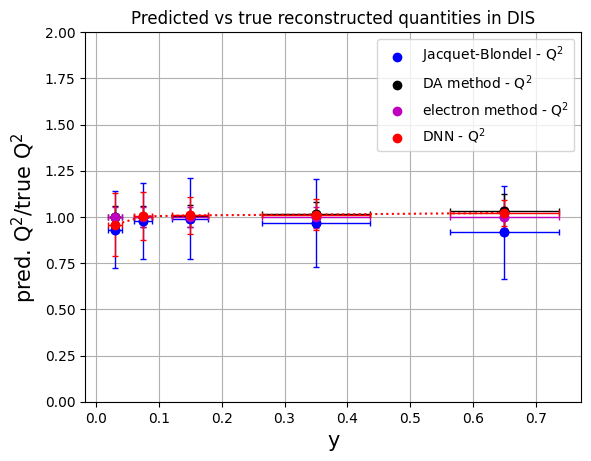

In [53]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined

meanQ2_jb = np.array(mean_Q2ratio[0:5])
errQ2_jb = np.array(rms_Q2ratio[0:5])

meanQ2_da = np.array(mean_Q2ratio[5:10])
errQ2_da = np.array(rms_Q2ratio[5:10])

meanQ2_e = np.array(mean_Q2ratio[10:15])
errQ2_e = np.array(rms_Q2ratio[10:15])

meanQ2_dnn = np.array(mean_Q2ratio[15:20])
errQ2_dnn = np.array(rms_Q2ratio[15:20])

plt.scatter(ykin, meanQ2_jb, color='b', label='Jacquet-Blondel - Q$^{2}$')
plt.errorbar(ykin, meanQ2_jb, xerr=err_ykin, yerr=errQ2_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meanQ2_da, color='k', label='DA method - Q$^{2}$')
plt.errorbar(ykin, meanQ2_da, xerr=err_ykin, yerr=errQ2_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meanQ2_e, color='m', label='electron method - Q$^{2}$')
plt.errorbar(ykin, meanQ2_e, xerr=err_ykin, yerr=errQ2_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meanQ2_dnn, color='r', label='DNN - Q$^{2}$')
plt.errorbar(ykin, meanQ2_dnn, xerr=err_ykin, yerr=errQ2_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. Q$^{2}$/true Q$^{2}$',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()

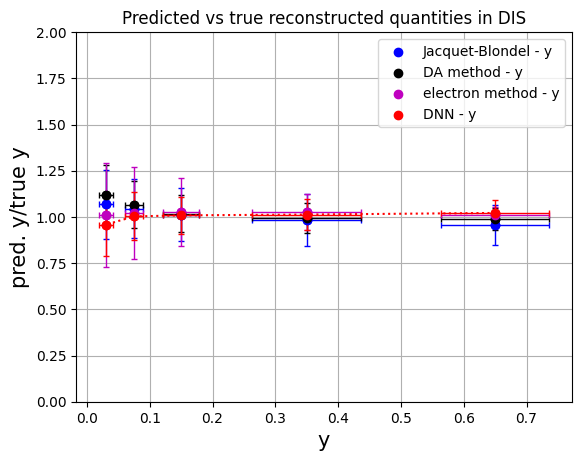

In [54]:

# convert to numpy arrays for manipulation
# methods: 'Jacquet-Blondel', 'DA method', 'e method', 'Deep NN'

y_ranges = [ (0.5, 0.8), (0.2, 0.5), (0.1, 0.2), (0.05, 0.1), (0.01, 0.05)] #---previously defined


meany_jb = np.array(mean_yratio[0:5])
erry_jb = np.array(rms_yratio[0:5])

meany_da = np.array(mean_yratio[5:10])
erry_da = np.array(rms_yratio[5:10])

meany_e = np.array(mean_yratio[10:15])
erry_e = np.array(rms_yratio[10:15])

meany_dnn = np.array(mean_yratio[15:20])
erry_dnn = np.array(rms_yratio[15:20])

plt.scatter(ykin, meany_jb, color='b', label='Jacquet-Blondel - y')
plt.errorbar(ykin, meany_jb, xerr=err_ykin, yerr=erry_jb, fmt='o', color='b', ecolor='b', elinewidth=1, capsize=2) #label='uncertainty'

plt.scatter(ykin, meany_da, color='k', label='DA method - y')
plt.errorbar(ykin, meany_da, xerr=err_ykin, yerr=erry_da, fmt='o', color='k', ecolor='k', elinewidth=1, capsize=2)

plt.scatter(ykin, meany_e, color='m', label='electron method - y')
plt.errorbar(ykin, meany_e, xerr=err_ykin, yerr=erry_e, fmt='o', color='m', ecolor='m', elinewidth=1, capsize=2)

plt.scatter(ykin, meany_dnn, color='r', label='DNN - y')
plt.errorbar(ykin, meany_dnn, xerr=err_ykin, yerr=erry_dnn, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, linestyle=':')


plt.xlabel('y',fontsize=15)
plt.ylabel('pred. y/true y',fontsize=15)
plt.ylim(0.,2.)
plt.title('Predicted vs true reconstructed quantities in DIS')
plt.legend()
plt.grid(True)
plt.show()